# Time Series Forecasting

In this notebook, we'll move from understanding the past to estimating the future.

Our goals are to:
- Learn how forecasting works conceptually
- Build simple, interpretable forecasting models
- Respect the time order of data
- Evaluate forecasts properly
- Understand limitations of forecasts

Forecasting is about reasonable estimates, not perfect predictions.


## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

We'll use StatsModels for classical time series models and Sklearn for error measurement (only metrics, nothing else).


## Load the Dataset

In [3]:
df = pd.read_csv("nutrition_data.csv")
df.head()

,Date,Meal,Food_Item,Calories,Protein_g,Carbs_g,Fat_g,Meal_Time,Water_ml
0,2022-01-11,Breakfast,Pancakes,349.0,15.0,67.3,NaN,08:00,2036.0
1,2022-01-11,Lunch,Chicken,271.0,10.2,NaN,22.2,13:00,NaN
2,2022-01-11,Supper,Nuts,613.0,28.0,63.5,NaN,17:00,378.0
3,2022-01-11,Dinner,Fish,514.0,10.6,40.0,14.5,20:30,133.0
4,2022-01-12,Breakfast,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Prepare the date column and index.

In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

### Create a Daily Time Series

Forecasting works best with one value per time step. We'll forecast daily calorie intake.

In [5]:
daily_calories = df["Calories"].resample("D").sum()
daily_calories = daily_calories.ffill()

### Visualizing the Series Before Forecasting

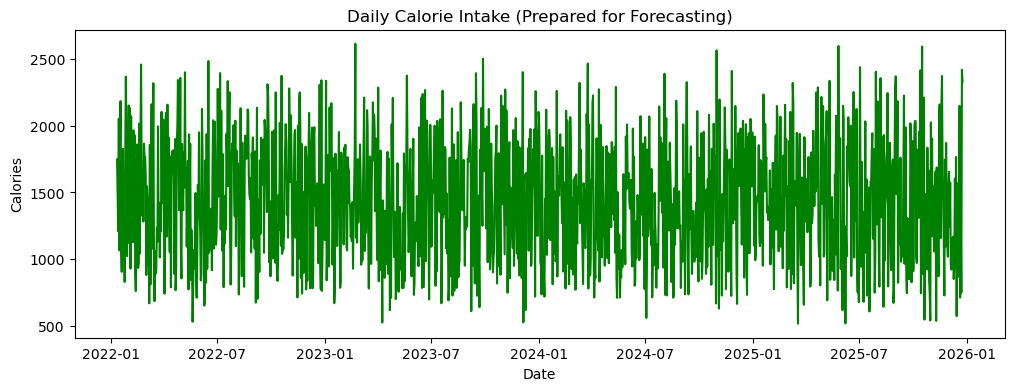

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(daily_calories, c="g")
plt.title("Daily Calorie Intake (Prepared for Forecasting)")
plt.xlabel("Date")
plt.ylabel("Calories")
plt.show()

## Train–Test Split

Time series must never be split randomly. We split based on time order.

In [7]:
train_size = int(len(daily_calories) * 0.8)

train = daily_calories.iloc[:train_size]
test = daily_calories.iloc[train_size:]

## Baseline Model: Naive Forecast

Before fancy models, always start simple. Naive Forecast Logic is actually naive. It assumes **Tomorrow will be the same as today.** 😅

In a Time-Series Forecasting way, **The next time step equals the most recent observed value.**

Mathematically, $\hat{y}_{t+1} = y_t$

### Why people call it **Naive**? Because,

* It ignores trends, seasonality, and external factors
* It uses **only one piece of information**: the latest value
* It's intentionally simple

The exact interpretation depends on the data frequency:

* **Daily data**: tomorrow = today
* **Monthly data**: next month = this month
* **Hourly data**: next hour = this hour

So it's more accurate to say: **The next observation will be the same as the most recent one.**

### Why it's still useful?

Despite being simple, Naive Forecasting is:

* A **baseline** to beat
* Surprisingly strong for **random walk–like data**
* A great **sanity check** before using complex models

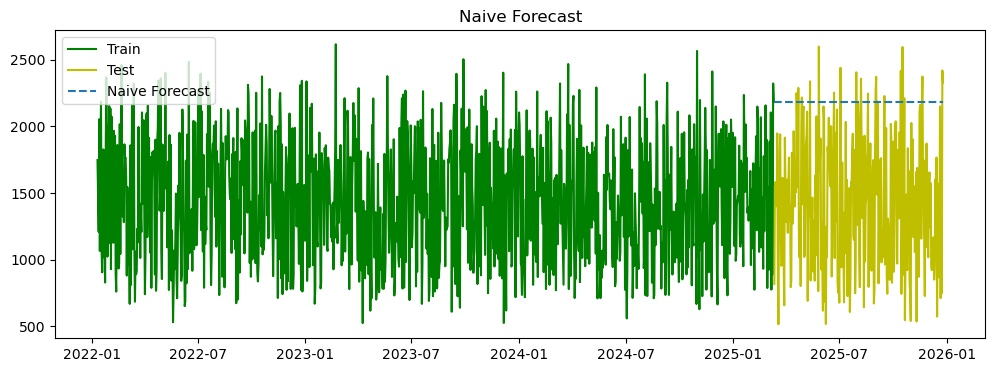

In [8]:
naive_forecast = test.copy()
naive_forecast[:] = train.iloc[-1]

plt.figure(figsize=(12, 4))
plt.plot(train, c="g", label="Train")
plt.plot(test, c="y", label="Test")
plt.plot(naive_forecast, label="Naive Forecast", linestyle="--")
plt.legend()
plt.title("Naive Forecast")
plt.show()

This baseline helps us answer: **Is our model better than doing nothing smart?**


### Evaluating the Naive Model

In [9]:
mae_naive = mean_absolute_error(test, naive_forecast)
rmse_naive = root_mean_squared_error(test, naive_forecast)

mae_naive, rmse_naive

(783.2698961937716, 903.5229874924797)

Let's keep these numbers as a reference point.


## Exponential Smoothing (Better Baseline)

This model gives more weight to recent observations. It is simple and very effective.

In [10]:
exp_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal=None
).fit()

exp_forecast = exp_model.forecast(len(test))

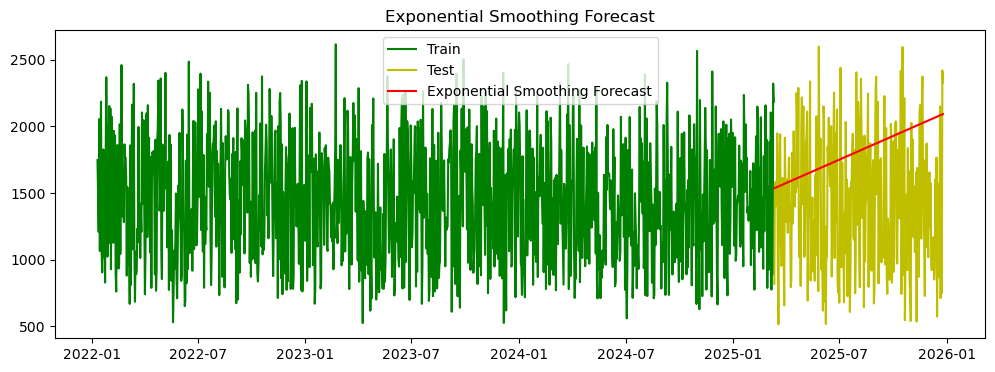

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(train, c="g", label="Train")
plt.plot(test, c="y", label="Test")
plt.plot(exp_forecast, c="r", label="Exponential Smoothing Forecast")
plt.legend()
plt.title("Exponential Smoothing Forecast")
plt.show()

### Evaluating Exponential Smoothing

In [12]:
mae_exp = mean_absolute_error(test, exp_forecast)
rmse_exp = root_mean_squared_error(test, exp_forecast)

mae_exp, rmse_exp

(533.5378607832586, 648.9159538480914)

### Now let's compare both of our results. What the numbers say?

| Model                 | MAE ↓      | RMSE ↓     |
| --------------------- | ---------- | ---------- |
| Naive                 | **783.27** | **903.52** |
| Exponential Smoothing | **533.54** | **648.92** |

Lower is better for both MAE and RMSE. Exponential Smoothing clearly beats the Naive baseline.

- MAE improved by ~32%
- RMSE improved by ~28%

That means, our exponential smoothing model is capturing structure (trend) that the naive model completely ignores. This is exactly what we want to see.


## ARIMA

Let's now try basic ARIMA, without over-tuning.

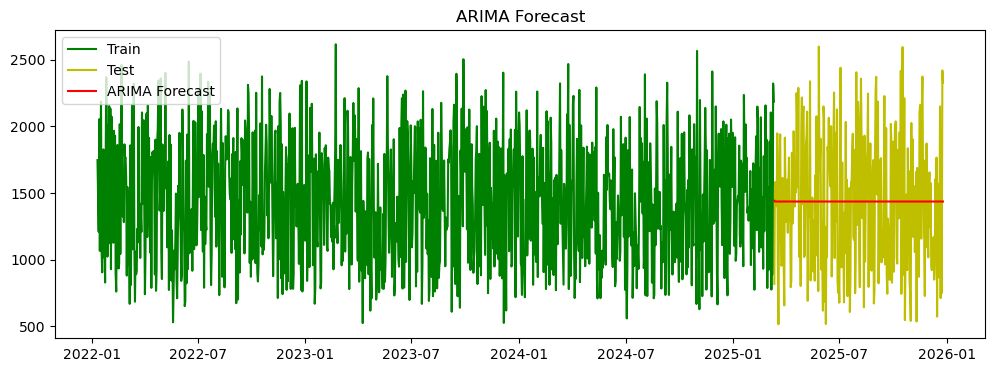

In [13]:
arima_model = ARIMA(train, order=(1, 1, 1)).fit()
arima_forecast = arima_model.forecast(steps=len(test))

plt.figure(figsize=(12, 4))
plt.plot(train, c="g", label="Train")
plt.plot(test, c="y", label="Test")
plt.plot(arima_forecast, c="r", label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast")
plt.show()


### Evaluating ARIMA

In [14]:
mae_arima = mean_absolute_error(test, arima_forecast)
rmse_arima = root_mean_squared_error(test, arima_forecast)

mae_arima, rmse_arima

(409.99122724000745, 485.98370337392896)

### Comparing All Models

In [15]:
results = pd.DataFrame({
    "Model": ["Naive", "Exponential Smoothing", "ARIMA"],
    "MAE": [mae_naive, mae_exp, mae_arima],
    "RMSE": [rmse_naive, rmse_exp, rmse_arima]
})

results

,Model,MAE,RMSE
0,Naive,783.269896,903.522987
1,Exponential Smoothing,533.537861,648.915954
2,ARIMA,409.991227,485.983703


#### Model Comparison Insights

- ARIMA vs Naive
    - MAE improved by ~48%
    - RMSE improved by ~46%
- ARIMA vs Exponential Smoothing
    - MAE improved by ~23%
    - RMSE improved by ~25%

ARIMA clearly outperforms both naive and ETS models, reducing forecast error by nearly half relative to the baseline and about a quarter beyond ETS, showing strong exploitable autocorrelation.

#### Key Takeaways

- Always start with a baseline
- Respect time order in splitting data
- Simpler models often work surprisingly well
- Forecasts are estimates, not facts
- Evaluation matters more than fancy models

#### Notebook Summary

- Forecasting builds on clean time series
- Train–test split must be time-aware
- Naive models are essential benchmarks
- Classical models are powerful and interpretable
- Understanding > complexity